# Machine Learning Model ANN

In [252]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense

warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(15,10)})
warnings.filterwarnings('ignore')

In [253]:
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

In [254]:
# Dataset generated in previous phase
data = pd.read_csv('./data_f1/cleaned_data.csv')

In [255]:
x = data[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_reliability','active_driver','active_constructor']]

In [256]:
x = x[x['active_constructor']==1]
x = x[x['active_driver']==1]

In [257]:
sc  = StandardScaler()
le = LabelEncoder()
x['GP_name'] = le.fit_transform(x['GP_name'])
x['constructor'] = le.fit_transform(x['constructor'])
x['driver'] = le.fit_transform(x['driver'])
x['GP_name'] = le.fit_transform(x['GP_name'])
X = x.drop(['position','active_driver','active_constructor'],1)
y = x['position'].apply(lambda x: position_index(x))

In [258]:
# Separate the test data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [259]:
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)

In [260]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(6,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [261]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 32)                224       
                                                                 
 dense_77 (Dense)            (None, 32)                1056      
                                                                 
 dense_78 (Dense)            (None, 32)                1056      
                                                                 
 dense_79 (Dense)            (None, 32)                1056      
                                                                 
 dense_80 (Dense)            (None, 16)                528       
                                                                 
 dense_81 (Dense)            (None, 4)                 68        
                                                                 
Total params: 3,988
Trainable params: 3,988
Non-train

In [262]:
opt = optimizers.Adamax(learning_rate=0.01)
model.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [263]:
callback_list = [
       tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=7,
            restore_best_weights=True,
            verbose=1
       )         
]

In [264]:
res = model.fit(x=X_train, 
                y=y_train, 
                epochs=50,
                validation_split=0.2,
                callbacks=callback_list)

Epoch 1/50
55/55 [==============================] - 1s 4ms/step - loss: 0.7861 - accuracy: 0.7042 - val_loss: 0.6249 - val_accuracy: 0.7648
Epoch 2/50
55/55 [==============================] - 0s 2ms/step - loss: 0.5350 - accuracy: 0.7950 - val_loss: 0.5289 - val_accuracy: 0.7991
Epoch 3/50
55/55 [==============================] - 0s 2ms/step - loss: 0.4775 - accuracy: 0.8218 - val_loss: 0.4467 - val_accuracy: 0.8151
Epoch 4/50
55/55 [==============================] - 0s 2ms/step - loss: 0.4313 - accuracy: 0.8355 - val_loss: 0.4095 - val_accuracy: 0.8470
Epoch 5/50
55/55 [==============================] - 0s 2ms/step - loss: 0.3880 - accuracy: 0.8681 - val_loss: 0.3738 - val_accuracy: 0.8699
Epoch 6/50
55/55 [==============================] - 0s 2ms/step - loss: 0.3518 - accuracy: 0.8864 - val_loss: 0.3732 - val_accuracy: 0.8630
Epoch 7/50
55/55 [==============================] - 0s 2ms/step - loss: 0.3469 - accuracy: 0.8835 - val_loss: 0.3314 - val_accuracy: 0.8836
Epoch 8/50
55/55 [==

In [265]:
df = pd.DataFrame(res.history)
df

,loss,accuracy,val_loss,val_accuracy
0,0.786129,0.704169,0.624911,0.764840
1,0.535036,0.794974,0.528949,0.799087
2,0.477482,0.821816,0.446663,0.815068
3,0.431309,0.835523,0.409546,0.847032
4,0.387983,0.868075,0.373833,0.869863
5,0.351826,0.886351,0.373209,0.863014
6,0.346894,0.883495,0.331428,0.883562
7,0.310515,0.908053,0.323119,0.904110
8,0.312281,0.903484,0.311779,0.892694
9,0.290073,0.910908,0.340603,0.881279


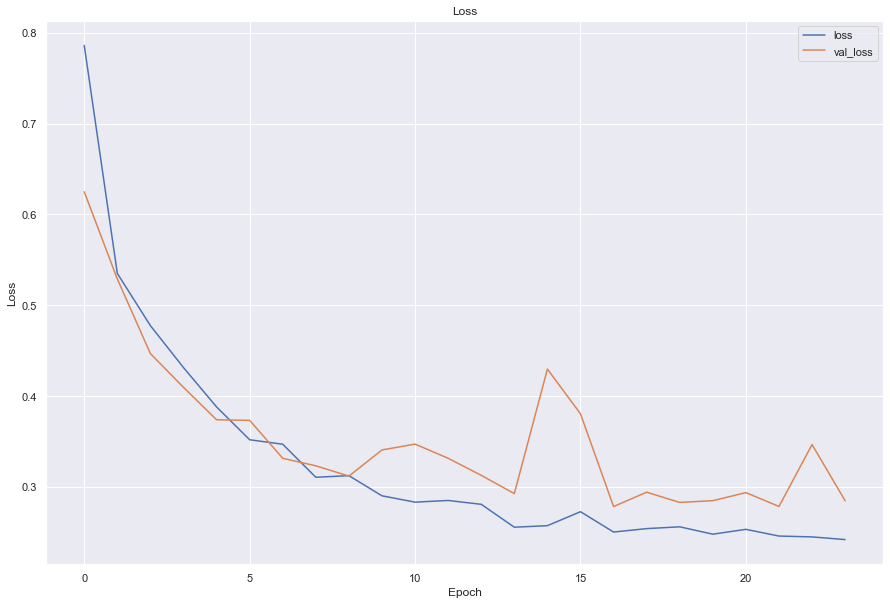

In [266]:
plt.plot(res.epoch, df.loss, label='loss')
plt.plot(res.epoch, df.val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

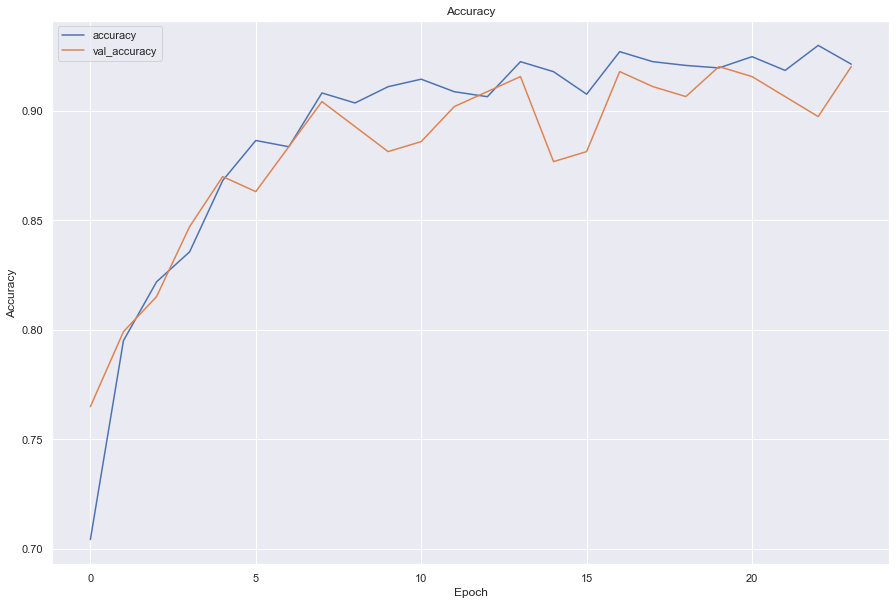

In [267]:
plt.plot(res.epoch, df.accuracy, label='accuracy')
plt.plot(res.epoch, df.val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [268]:
pred = model.predict(X_test)
pred = np.argmax(pred,1)
print('Misclassified examples: %d' % (y_test != pred).sum())

18/18 [==============================] - 0s 1ms/step
Misclassified examples: 42


In [269]:
# Evaluate model
(test_loss, test_accuracy) = model.evaluate(x=X_test,y=y_test)
print("Loss:", test_loss)
print('Accuracy', test_accuracy)

18/18 [==============================] - 0s 2ms/step - loss: 0.2495 - accuracy: 0.9234
Loss: 0.24946360290050507
Accuracy 0.9233576655387878


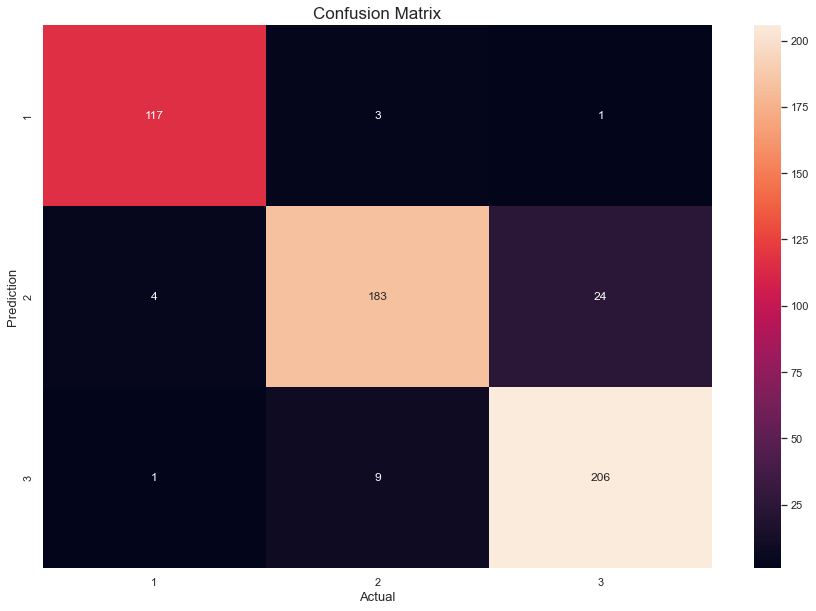

In [270]:
cm = confusion_matrix(y_test,pred)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['1','2','3'], yticklabels=['1','2','3'])

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [271]:
# save model
path='./web/model/model.h5'
model.save(path)